# TP2 : Interação e Concorrência

Cada grupo de estudantes tem um número atribuído e pretendemos utilizar um algoritmo quântico para encontrar o nosso número.
O nosso grupo de trabalho é o 1 e usaremos o algoritmo de Grover para o encontrar numa lista de 8 possíveis.
Assim, para representação dos números possíveis (0 a 7) teremos 3 qubits ($2^{3}=8$) e pretendemos encontrar a representação binária de 1 (001).

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
import math as m

In [2]:
backend_state = Aer.get_backend("statevector_simulator")
backend_unitary = Aer.get_backend('unitary_simulator')
backend = Aer.get_backend("qasm_simulator")

In [3]:
def intersperse(iterable, delimiter):
    it = iter(iterable)
    yield next(it)
    for x in it:
        yield delimiter
        yield x

def concat_circuits(circuits, barrier=None):
    if barrier:
        circuits = intersperse(circuits, barrier)
    
    ret = QuantumCircuit()
    for circuit in circuits:
        ret += circuit
    return ret

def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs).result()

def bloch_sphere(circuit, result):
    return plot_bloch_multivector(result.get_statevector(circuit))

def state_city(circuit, result):
    return plot_state_city(result.get_statevector(circuit))

def state_hinton(circuit, result):
    return plot_state_hinton(result.get_statevector(circuit))

def state_qsphere(circuit, result):
    return plot_state_qsphere(result.get_statevector(circuit))

def histogram(circuit, result):
    return plot_histogram(result.get_counts(circuit))

## 1. Inicialização
Pretendemos que todos os estados sejam verificados portanto criamos uma sobreposição uniforme de todas as possibilidades aplicando um Hadamard a cada qubit.   

$$ \frac{1}{\sqrt{N}} \sum_{x_i} \lvert x_i \rangle$$, sendo $N = 2^3 = 8$

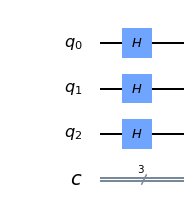

In [4]:
n = 3 # nº de bits
N = 2 ** n

cr = ClassicalRegister(n, 'c')
qr = QuantumRegister(n, 'q')

barrier = QuantumCircuit(qr, cr)
barrier.barrier()

init = QuantumCircuit(qr, cr)
init.h(qr)
init.draw('mpl')

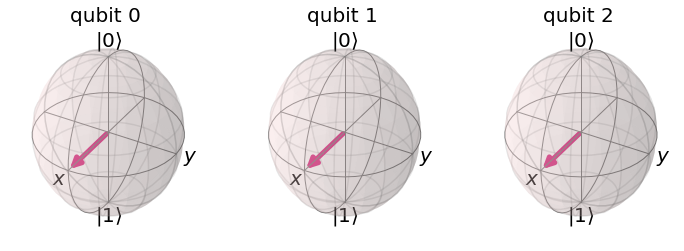

In [5]:
result = run(init, backend_state)
bloch_sphere(init, result)

Como podemos verificar, cada qubit está no estado de sobreposição |+> tendo igual probabilidade de ocorrer |0> como |1>.
Assim, todos os resultados têm igual probabilidade de ocorrer como podemos verificar na matriz seguinte.

In [6]:
result.get_statevector().real

array([0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
       0.35355339, 0.35355339, 0.35355339])

## 2. Oráculo
Pretendemos assinalar o nosso número de grupo mudando a fase da componente |001> **TODO** . Para isto optámos por um oráculo de fase que evita usar um qubit auxiliar diminuindo os erros na execução.   
O oráculo de fase consiste em selecionar a componente pretendida (|001>), aplicar um CCZ e reverter a seleção aplicada anteriormente.   
Uma vez que o operador CCZ não existe em qiskit decompusemo-lo em $(I \otimes I \otimes H) \cdot CNOT \cdot (I \otimes I \otimes H)$.   

$$-\alpha_{001} \lvert 001 \rangle + \beta \sum_{x_i \neq 001}\lvert x_i \rangle$$ 

In [7]:
def ccZ(circuit, c1, c2, t):
    circuit.h(t)
    circuit.ccx(c1, c2, t)
    circuit.h(t)
    
def phase_oracle(circuit, qr):
    circuit.x(qr[0])
    circuit.x(qr[1])
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr[0])
    circuit.x(qr[1])

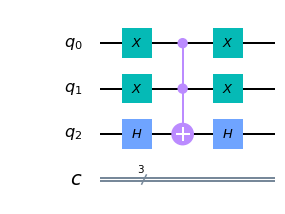

In [8]:
oracle = QuantumCircuit(qr, cr)
phase_oracle(oracle, qr)
oracle.draw('mpl')

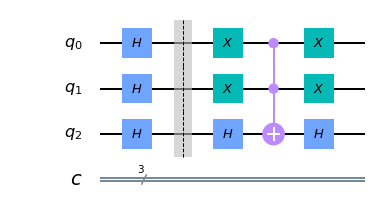

In [9]:
circuit = concat_circuits([ init, oracle ], barrier=barrier)
circuit.draw('mpl')

In [10]:
result = run(circuit, backend_state)
result.get_statevector(circuit).real

array([ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
        0.35355339,  0.35355339,  0.35355339])

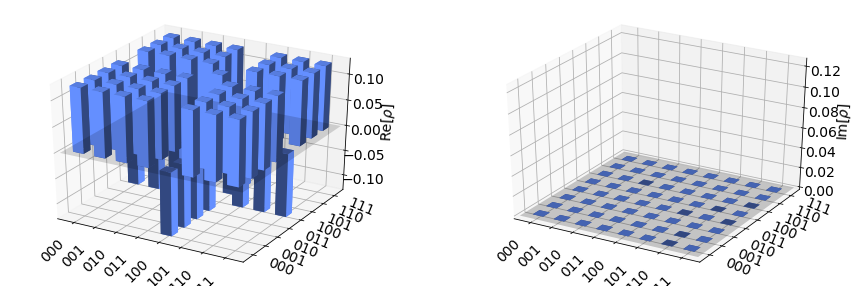

In [11]:
state_city(circuit, result)

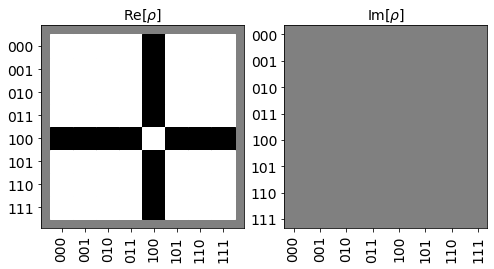

In [12]:
state_hinton(circuit, result)

Como se pode verificar a componente |100> (que representa o |001> pretendido) manteve a amplitude mas alterou a fase, tal como pretendíamos.

## 3. Amplificação

Apesar da mudança de fase, neste momento mantemos as probabilidades iguais para todos casos, o que não nos ajuda muito para o que pretendemos.
O objetivo desta secção é aumentar a probabilidade de obtermos o resultado pretendido.
Para isso, invertemos e aumentamos a amplitude da componente pretendida em torno da média das amplitudes ($A$) e simultaneamente reduzimos a amplitude das restantes componentes de forma uniforme.

$$(2A + \alpha_{001})\lvert 001 \rangle + (2A-\beta)\sum_{x_i\neq 001} \lvert x_i \rangle $$

In [13]:
def diffuser(circuit, qr):
    circuit.h(qr)
    circuit.x(qr)
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr)
    circuit.h(qr)

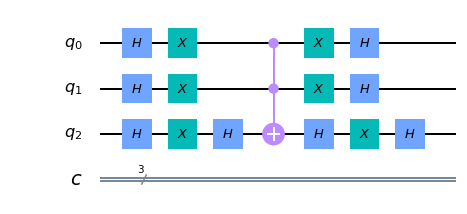

In [14]:
amplifier = QuantumCircuit(qr, cr)
diffuser(amplifier, qr)

amplifier.draw('mpl')

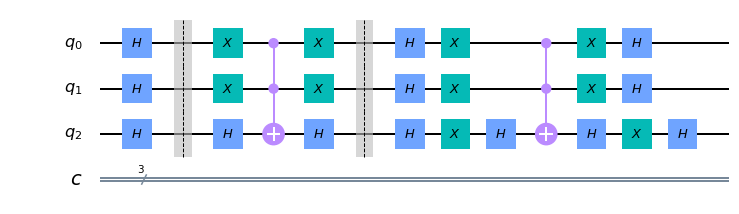

In [15]:
circuit = concat_circuits([ init, oracle, amplifier ], barrier=barrier)
circuit.draw('mpl')

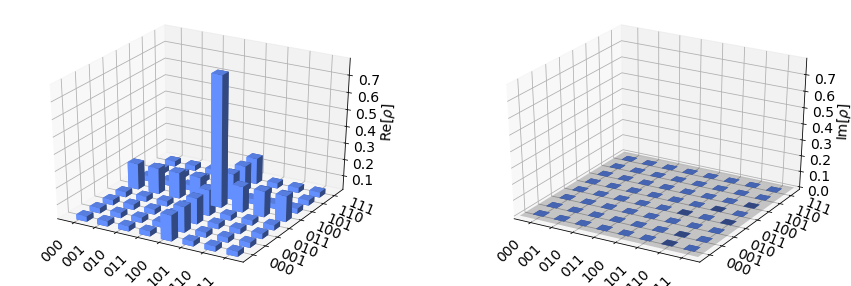

In [16]:
result = run(circuit, backend_state)
state_city(circuit, result)

Verificamos que a magnitude da componente |001> foi aumentada.

## 4. Medição
A medição é a projeção do estado quântico de cada um dos qubits para um bit clássico.
Ao ser medido, cada qubit colapsa para um dos estados possíveis, não sendo mais possível reconstruir o estado quântico inicial.

Apresentamos o circuito com as 4 secções referidas separadas por barreiras:

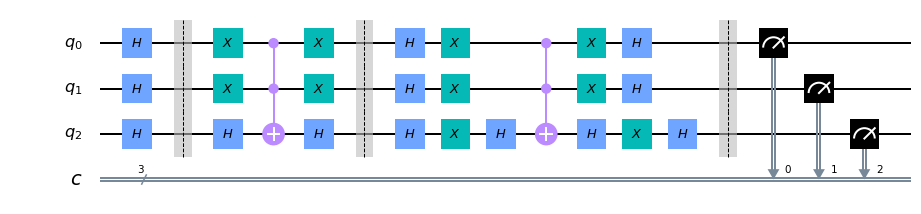

In [17]:
measurements = QuantumCircuit(qr, cr)
measurements.measure(qr, cr)

circuit = concat_circuits([ init, oracle, amplifier, measurements ], barrier=barrier)
circuit.draw('mpl')

### O iterador de Grover
Antes de fazermos as medições podemos melhorar a probabilidade de medirmos o valor pretendido.
Para isso, iremos repetir o iterador de Grover que consiste em aplicar o oráculo e a amplificação.
Lov Grover definiu que o número ideal de iterações é aproximadamente $\frac{\pi}{4}\sqrt{N}$, algo que podemos verificar de seguida.

In [18]:
times = round((m.pi/4) * m.sqrt(N))
times

2

### Uma iteração

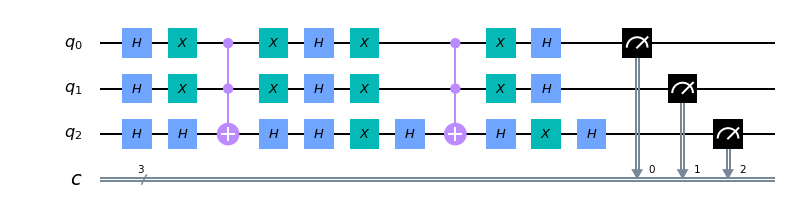

In [19]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 1) + [ measurements ])
circuit.draw('mpl')

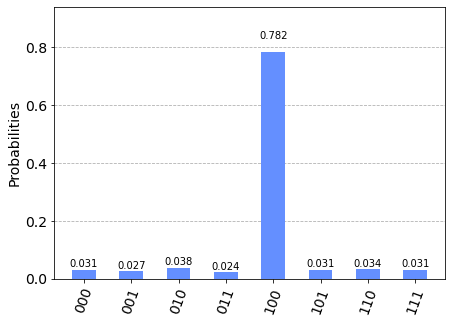

In [20]:
result = run(circuit, backend)
fst_loop_counts = result.get_counts(circuit)
plot_histogram(fst_loop_counts)

### Duas iterações

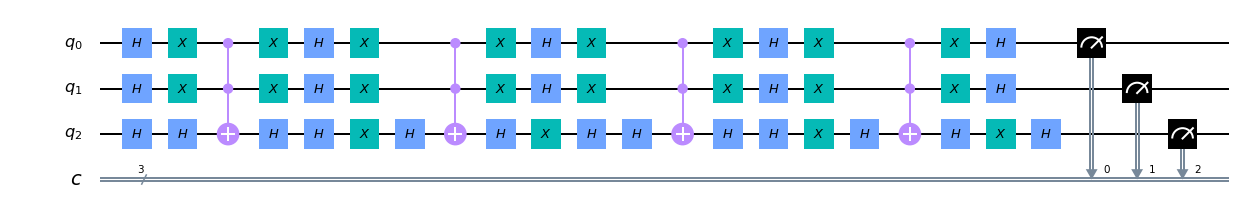

In [36]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 2) + [ measurements ])
circuit.draw('mpl')

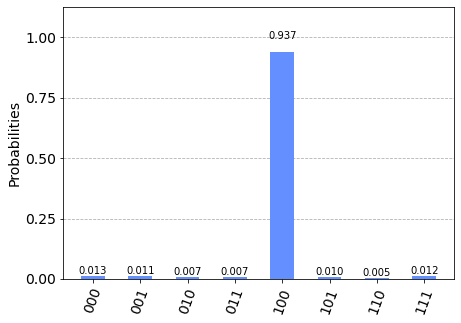

In [37]:
result = run(circuit, backend)
snd_loop_counts = result.get_counts(circuit)
plot_histogram(snd_loop_counts)

### Três iterações

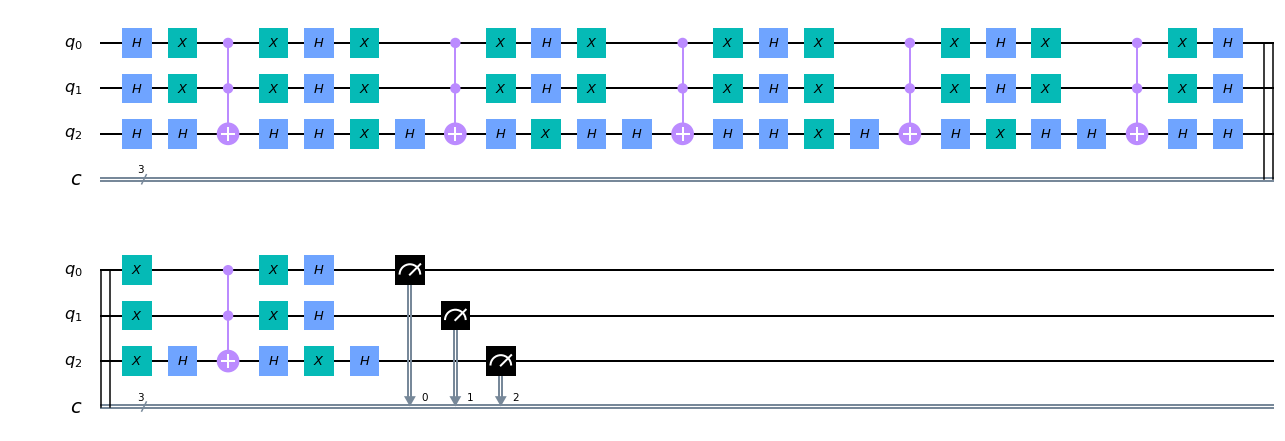

In [23]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 3) + [ measurements ])
circuit.draw('mpl')

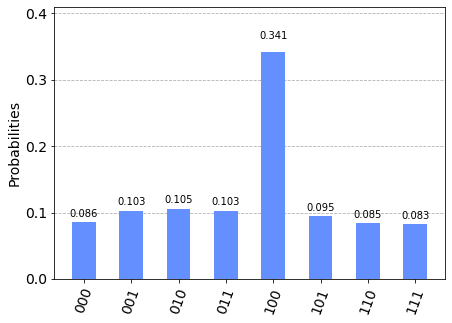

In [24]:
result = run(circuit, backend)
trd_loop_counts = result.get_counts(circuit)
plot_histogram(trd_loop_counts)

### Análise de resultados

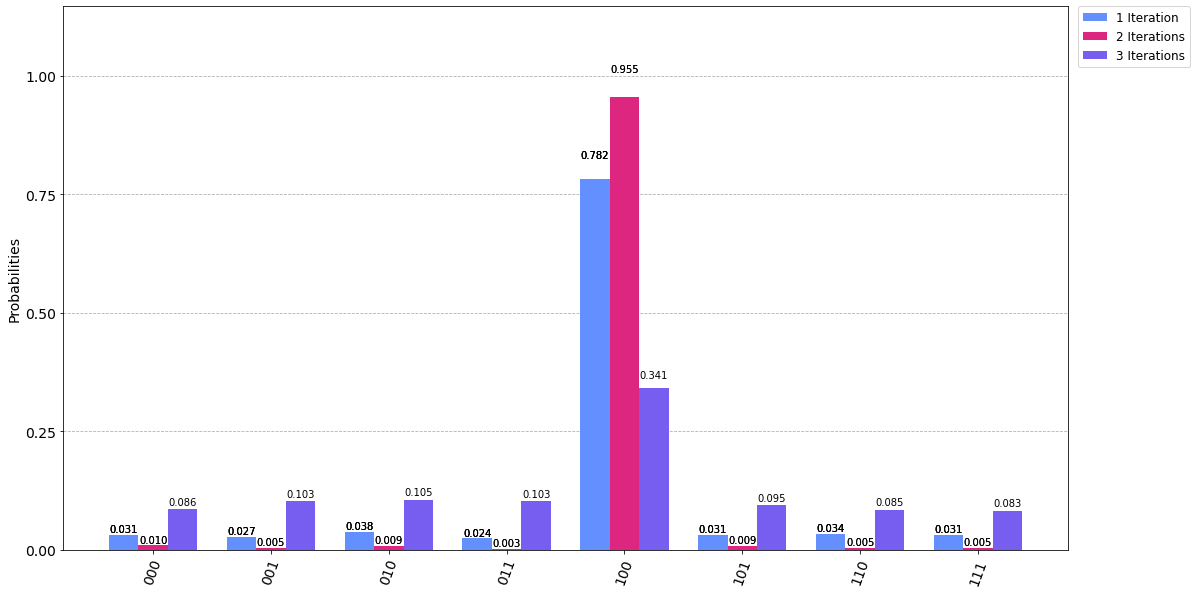

In [25]:
plot_histogram([ fst_loop_counts, snd_loop_counts, trd_loop_counts ], legend=[ "1 Iteration", "2 Iterations", "3 Iterations" ], figsize=(18, 10))

Como se pode verificar, houve um aumento significativo entre aplicar uma e duas iterações, no entanto ao aplicar uma terceira há uma diminuição substancial.

# Simulação de ruído

In [46]:
provider = IBMQ.load_account()

#remove simuladores e o ibmq_armonk
provider.backends( simulator=False, open_pulse=False)

ibmqfactory.load_account:WARNING:2020-06-18 23:02:22,965: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [29]:
import qiskit.tools.jupyter

%qiskit_backend_overview

In [43]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibmq_rome                    ibmq_armonk                  ibmq_essex
---------                    -----------                  ----------
Num. Qubits:  5              Num. Qubits:  1              Num. Qubits:  5
Pending Jobs: 7              Pending Jobs: 31             Pending Jobs: 11
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      70.6           Avg. T1:      152.2          Avg. T1:      117.0
Avg. T2:      92.8           Avg. T2:      174.6          Avg. T2:      149.5



ibmq_burlington              ibmq_london                  ibmq_ourense
---------------              -----------                  ------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 3              Pending Jobs: 6              Pending Jobs: 21
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           O

Tendo em conta o valor elevado do T1 e T2 - que se refere à média do tempo de vida dos qubits até chegar à decoerência - à reduzida taxa de erros de medida e cx, e ainda ao facto de ter uma boa disponibilidade optamos pelo *device backend* **ibmq_vigo**. 

In [30]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

# Define backend
backend_device = my_provider_ibmq.get_backend('ibmq_vigo')

# See backend information
backend_device

<IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [33]:
coupling_map = backend_device.configuration().coupling_map

from qiskit.providers.aer.noise import NoiseModel

# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(backend_device)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'cx', 'measure', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [34]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'u2', 'u3']


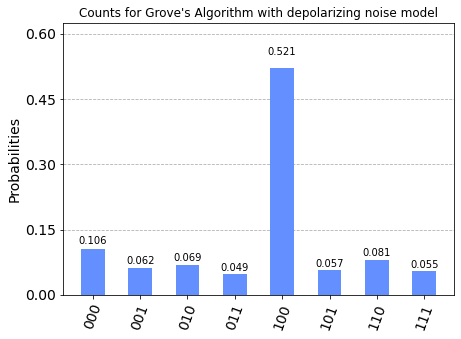

In [48]:
# Execute noisy simulation and get counts
result_noise = execute(circuit,
                       backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(circuit)
plot_histogram(counts_noise, title="Counts for Grove's Algorithm with depolarizing noise model")

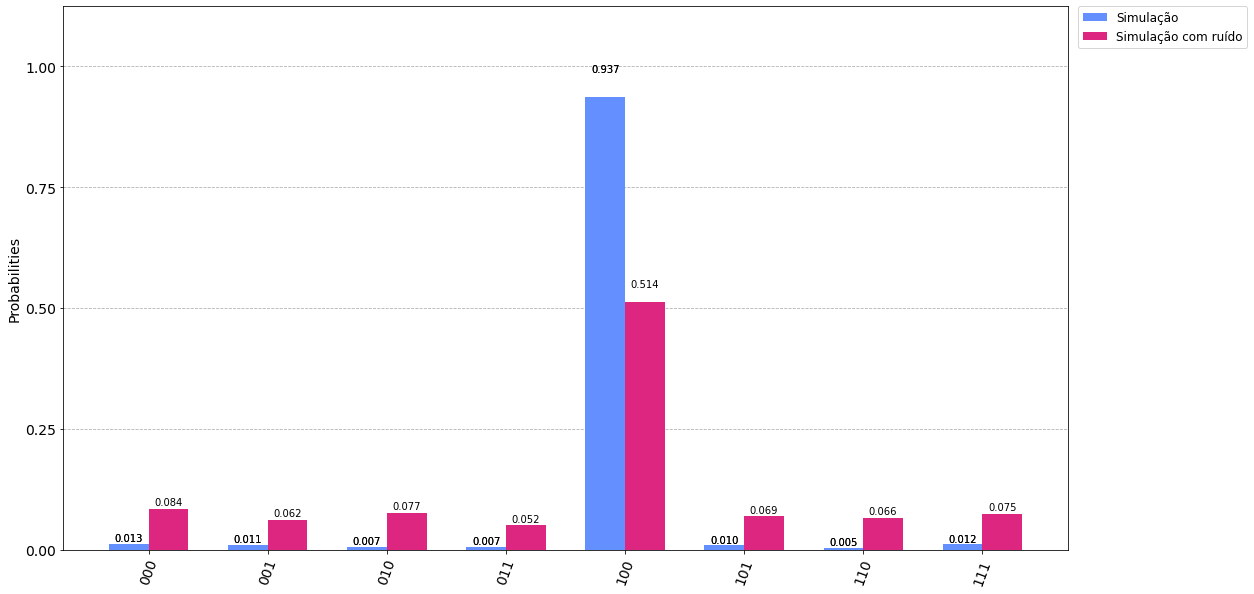

In [40]:
plot_histogram([snd_loop_counts, counts_noise], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

Podemos ver que os erros produzidos pelo ruído no backend device serão significativos pelo que devemos optimizar o circuito de forma a reduzir a taxa de erro.

# Optimização do circuito

## Optimização com outro nome
Após simulação com ruído do backend device selecionado vamos executar nesse mesmo backend device para podermos fazer uma análise mais correcta do ganho efectivo na optimização.

In [47]:
backend_monitor(backend_device)

ibmq_vigo
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 4
    backend_version: 1.0.2
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    open_pulse: False
    description: 5 qubit device Vigo
    quantum_volume: 16
    max_shots: 8192
    online_date: 2019-07-03T04:00:00+00:00
    n_registers: 1
    max_experiments: 75
    meas_map: [[0, 1, 2, 3, 4]]
    sample_name: Giraffe
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
    conditional: False
    credits_required: True
    allow_object_storage: True
    memory: True
    allow_q_object: True
    backend_name: ibmq_vigo
    url: None

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 4.79643 GHz / 123.90218 µs / 17.14151 µs / 0.0 / 0.00045 / 0.0009 / 0.015
    Q1 / 4.94015 GHz / 108.89733 µs / 132.3511 

In [52]:
shots=1024

#executar o circuito na máquina real
job_DJ_r = execute(circuit, backend_device, shots=shots)

jobID_DJ_r = job_DJ_r.job_id()

print('JOB ID: {}'.format(jobID_DJ_r))

JOB ID: 5eebe713bc8e9400199b6424


In [53]:
%qiskit_job_watcher ## widget para visualizar o estado da job
#%qiskit_disable_job_watcher  ## para fechar o widget

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [56]:
# Recolha de resultados do job executado no backend device
job_get=backend_device.retrieve_job("5eebe713bc8e9400199b6424")


result_G = job_get.result()
counts_G = result_G.get_counts(circuit)

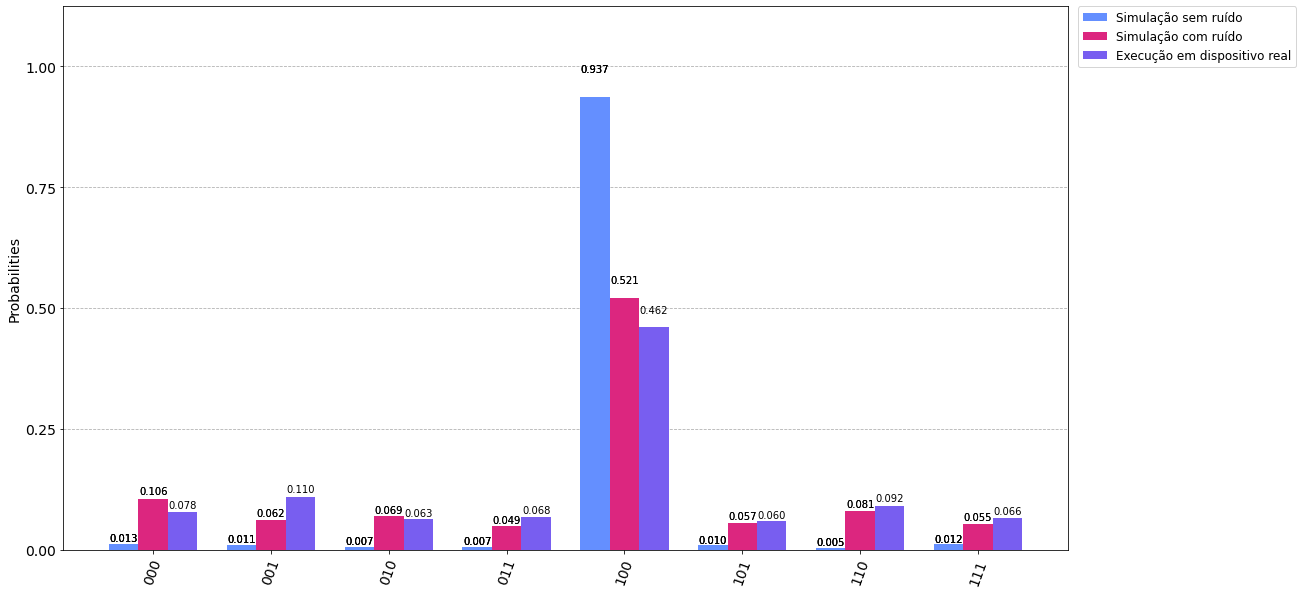

In [58]:
plot_histogram([snd_loop_counts, counts_noise, counts_G], legend=[ "Simulação sem ruído", "Simulação com ruído", "Execução em dispositivo real"], figsize=(18, 10))

**TODO**Agora vamos fazer cenas que ainda não sabemos bem como acontecem mas devemos falar sobre elas.

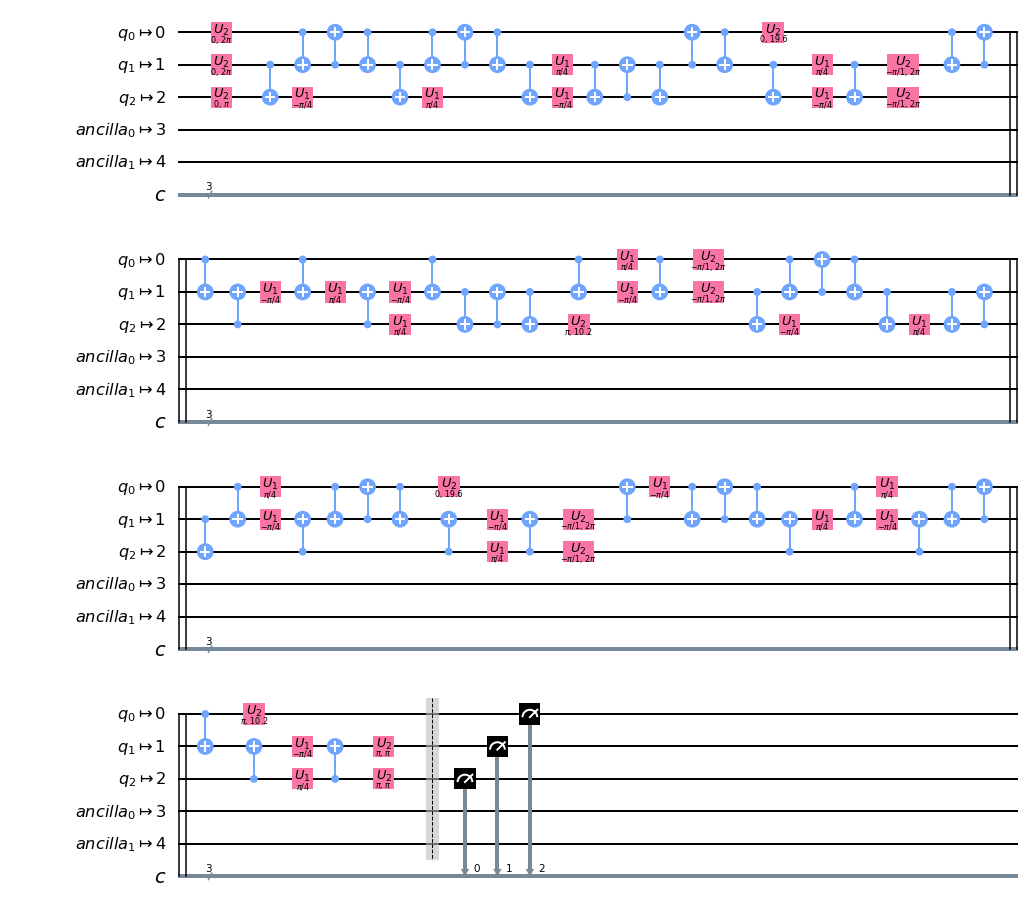

In [66]:
from qiskit.compiler import transpile

circuit_real = transpile(circuit, backend=backend_device)
circuit_real.draw(output='mpl', scale=0.5)

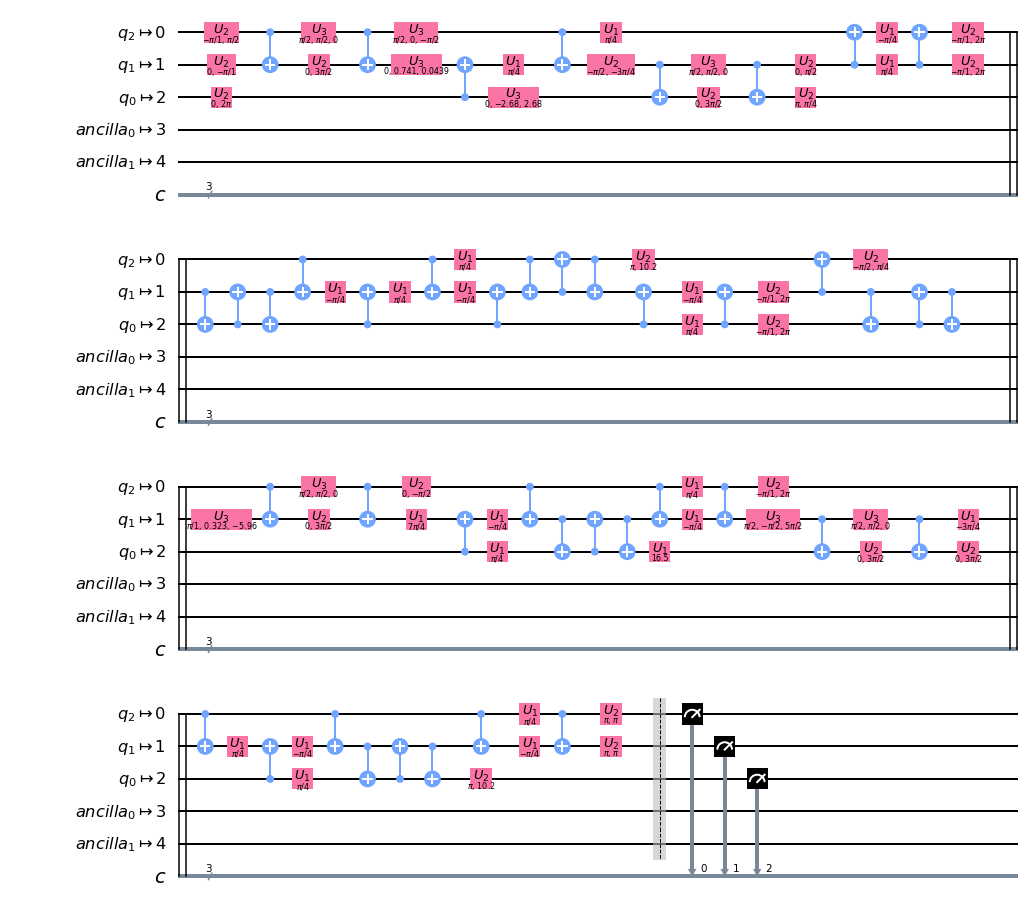

In [67]:
circuit_opt = transpile(circuit, backend=backend_device, optimization_level=3)
circuit_opt.draw(output='mpl', scale=0.5)

In [73]:
dc=circuit.depth()
dr=circuit_real.depth()
do=circuit_opt.depth()

print("= Circuit depth = circuit:",dc," | circuit_real:",dr," | circuit_opt:",do)

= Circuit depth = circuit: 22  | circuit_real: 74  | circuit_opt: 70


**WHAT?! NÃO FAZ SENTIDO** ..to be continued

## Optimização com diminuição de gates ?

In [ ]:
cr = ClassicalRegister(n, 'c')
qr = QuantumRegister(n, 'q')

qc_short = QuantumCircuit(qr, cr)

qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])
#qc_short.h(qr[2])
#qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.h(qr[2])
    qc_short.z(qr[2])
else:
    qc_short.x(qr[2])
    qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.z(qr[2])
    qc_short.h(qr[2])
else:
    qc_short.h(qr[2])
    qc_short.x(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.h(qr[2])
    qc_short.z(qr[2])
else:
    qc_short.x(qr[2])
    qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.z(qr[2])

#qc_short.barrier()

qc_short.measure(qr, cr)

qc_short.draw('mpl')

In [ ]:
result = run(qc_short, backend)
histogram(qc_short, result)